# Реализация методов кросс-валидации

In [3]:
#!pip install tscv  #никто не запрещал, так что :)
#!pip install statsmodels --upgrade

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from tscv import GapKFold

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
import warnings
warnings.filterwarnings("ignore") 

В данном разделе вам предлагается реализовать методы кросс-валидации, описанные в статье https://arxiv.org/pdf/1905.11744.pdf, которую мы разбирали на семинаре. Реализуйте все методы, перечисленные в классе. В случае, если в классе понадобятся дополнительные параметры, доопределите их самостоятельно.


0.7 балла за каждый из девяти методов оценки ошибки (Максимум 6.3)

Ещё 0.7 за реализацию оставшихся методов класса и функции model_fit.

Итого, максимум 7 баллов за раздел

In [3]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
class CVMethods:
    def __init__(self, ts, proportion, nfolds, cv_gap, p, nreps):

        breakpoint = int(len(ts) * proportion)
        # Разбиваем ряд на оценку и валидацию
        self.est = ts[:breakpoint]
        self.val = ts[breakpoint:]

        # Устанавливаем количество фолдов для prequential и cv методов.
        self.nfolds = nfolds

        # Устанавливаем длину разрыва (в точках) для cv_hv_blocked
        self.cv_gap = cv_gap
        #cv_gap = int(breakpoint * 0,05)

        # Устанавливаем порядок авторегрессии для этого ряда
        self.p = p

        # Устанавливаем количество повторов rep_holdout
        self.nreps = nreps

    def model_fit(self, y_train, y_test):
        """Функция, возвращающая ошибку на тесте для авторегрессии"""
    
        model = AutoReg(y_train, self.p).fit()
        y_pred = model.forecast(steps = len(y_test))
        return MAPE(y_test, y_pred)

    def get_Lm(self):
        """Метод, возвращающий 'истинную' ошибку модели.
         Банально обучаем авторегрессию на всей части est и прогнозируем на val."""

        result = self.model_fit(self.est, self.val)
        return result
    
    def get_all_metrics(self):
        """Метод, возвращающий вектор из всех нижеперечисленных метрик"""
        return np.array([
                         self.get_holdout(), self.get_rep_holdout(),
                         self.get_preq_expanding(), self.get_preq_slinidg(),
                         self.get_preq_expanding_with_gap(), self.get_cv_blocked(),
                         self.get_cv_hv_blocked(), self.get_simple_expanding(),
                         self.get_simple_sliding()
                         ])

    def get_holdout(self):
        """
        Берем случайную точку (порог) на ряде 
        (в разумных пределах, я взяла от 70 до 90% от ряда, о чем писали в беседе) и считаем, что все,
        что до этого порога - train, а все что после - test
        """
        bp = np.random.randint(len(self.est) * 0.7, len(self.est) * 0.9)
        y_train = self.est[:bp]
        y_test = self.est[bp:]
        return self.model_fit(y_train, y_test)

    def get_rep_holdout(self):
        """
        Как get_holdout, только повторяем nreps раз
        """
        result = []
        for i in range(self.nreps):
            bp = np.random.randint(len(self.est) * 0.7, len(self.est) * 0.9)
            y_train = self.est[:bp]
            y_test = self.est[bp:]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

    def get_preq_expanding(self):
        """
        Просто делим ряд на nfolds блоков и делаем метод расширяющегося окна с шагом = 1 блоку
        т.е. сначала train - первый блок, test - второй, 
        на 2 шаге train - первые два, test - третий и т.д. до конца ряда
        """
        tscv = TimeSeriesSplit(n_splits = self.nfolds)
        result = []
        for train_index, test_index in tscv.split(self.est):
            y_train = self.est[train_index]
            y_test = self.est[test_index]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

    def get_preq_slinidg(self):
        """
        Делим ряда на nfolst блоков и делаем метод сдвигающегося окна с шагом = 1 блоку
        т.е. на 1 шаге train - первый блок, test - второй,
        на 2 шаге train - второй, test - третий и т.д. до конца ряда
        """
        tscv = TimeSeriesSplit(n_splits = self.nfolds)
        result = []
        for train_index, test_index in tscv.split(self.est):
            y_train = self.est[train_index]
            y_train = y_train[-len(test_index):]
            y_test = self.est[test_index]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

    def get_preq_expanding_with_gap(self):
        """
        Как get_preq_expanding, только пропускаем 1-ый шаг кросс-валидации и далее перед test блоком 
        оставляем зазор - gap (то есть просто не учитываем эти значенияряда) равный идущему 
        перед текущим test блоком блоку (то есть просто предыдущий test) 
        """
        tscv = TimeSeriesSplit(n_splits = self.nfolds)
        result = []
        y_test = []
        i = 1
        for train_index, test_index in tscv.split(self.est):
            if i != 1:
                train_index = np.setdiff1d(train_index, gap_index)
                y_train = self.est[train_index]
                y_test = self.est[test_index]
                result.append(self.model_fit(y_train, y_test))
            gap_index = test_index
            i += 1

        return np.mean(result)
    
    def get_cv_blocked(self):
        """
        Делим ряд на nfolds блоков и на i (подразумеваю, что шаг от 1 до nfolds) шаге считаем test -
        это i-ый блок, в train - все, кроме i-ого
        """
        result = []
        cv = KFold(n_splits=self.nfolds)
        for train_index, test_index in cv.split(self.est):
            y_train = self.est[train_index]
            y_test = self.est[test_index]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)
        
    def get_cv_hv_blocked(self):
        """
        То же, что и get_cv_blocked, но выкидываем по cv_gap / 2 элементов ряда с каждой стороны от test
        """
        result = []
        cv = GapKFold(n_splits=self.nfolds, gap_before=self.cv_gap/2, gap_after=self.cv_gap/2)
        for train_index, test_index in cv.split(self.est):
            y_train = self.est[train_index]
            y_test = self.est[test_index]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

    def get_simple_expanding(self):
        """
        Задаем изначальные train, test размера равному одному блоку кросс-валидации,
        затем проходимся по self.est, расширяя train на 1 значение на каждом шаге
        => test сдвигается на 1 значение
        """

        result = []
        size = len(self.est) // self.nfolds
        for i in range(len(self.est) - 2 * size):
            y_train = self.est[:size + i]
            y_test = self.est[size + i : 2 * size + i]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

    def get_simple_sliding(self):
        """Задаем изначальные train, test размера равному одному блоку кросс-валидации,
        затем проходимся по self.estб сдвигая train и test На 1 значение на каждом шаге
        """
        result = []
        size = len(self.est) // self.nfolds
        for i in range(len(self.est) - 2 * size):
            y_train = self.est[i : size + i]
            y_test = self.est[size + i : 2 * size + i]
            result.append(self.model_fit(y_train, y_test))

        return np.mean(result)

# Тестирование результатов

## Героическая загрузка данных и формирование набора из 10 рядов (1 балл)

Подберите 10 любых рядов. Из них 5 нестационарных, 5 стационарных. Желательно, чтобы они были относительно разнообразными (лучше не брать ВВП и потребление из предыдущего ДЗ, но можно, если совсем всё плохо.) Самый простой способ -- взять 5 нестационарных рядов и сделать из них ещё 5 стационарных путём взятия разностей. Например, можно взять ряды из датасетов M3 или M4. Я когда-то для курсача сэмплировал небольшую подборку рядов из M4, можете использовать их либо найти любые другие данные. Сэмпл лежит в папке с заданием. Если не хотите слишком долго считать, избегайте слишком длинных рядов, в частности с часовой периодичностью.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
df_d = pd.read_csv('/content/gdrive/My Drive/Daily_sample.csv')
df_y = pd.read_csv('/content/gdrive/My Drive/Yearly_sample.csv')
df_1 = pd.read_csv('/content/gdrive/My Drive/gold_price_data.csv')
df_2 = pd.read_csv('/content/gdrive/My Drive/yahoo_stock.csv')
df_8 = pd.read_csv('/content/gdrive/My Drive/CME_HO1.csv')

In [7]:
series_1 = np.concatenate((df_d['3'].values, df_d['4'].values))
diff_1 = np.diff(series_1) + 2

series_2 = df_1.loc[9691:, 'Value'].values
diff_2 = np.diff(series_2) + 85

series_3 = np.flip(df_2['High'].values)
diff_3 = np.diff(series_3) + 160

series_4 = df_8['Close'].values
diff_4 = np.diff(series_4) + 1

series_5 = df_1.loc[5000:7100, 'Value'].values
diff_5 = np.diff(np.diff(series_5)) + 40

Для стационарных рядов делаем сдвиг так, чтобы не было нулевых значений. А то MAPE у нас метрика капризная...

In [11]:
def stationarity_check(series):
    test_1 = adfuller(series, regression='ct')
    if (test_1[0] > test_1[4]['5%']): 
        res1 = 'ADF: ряд не стационарен'
    else:
        res1 = 'ADF: ряд стационарен'

    test_2 = kpss(series, regression='ct')
    if (test_2[0] > test_2[3]['5%']): 
        res2 = 'KPSS: ряд не стационарен'
    else:
        res2 = 'KPSS: ряд стационарен'

    return (res1, res2)

Теперь проверим взятые ряды на стационарность

In [12]:
print(stationarity_check(series_1))
print(stationarity_check(series_2))
print(stationarity_check(series_3))
print(stationarity_check(series_4))
print(stationarity_check(series_5))

('ADF: ряд не стационарен', 'KPSS: ряд не стационарен')
('ADF: ряд не стационарен', 'KPSS: ряд не стационарен')
('ADF: ряд стационарен', 'KPSS: ряд не стационарен')
('ADF: ряд не стационарен', 'KPSS: ряд не стационарен')
('ADF: ряд не стационарен', 'KPSS: ряд не стационарен')


Будем руководствоваться тем, что было написано в прошлом дз и слушать KPSS, а не ADF в случае расхождения их результатов

А теперь их разности на стационарность

In [13]:
print(stationarity_check(diff_1))
print(stationarity_check(diff_2))
print(stationarity_check(diff_3))
print(stationarity_check(diff_4))
print(stationarity_check(diff_5))

('ADF: ряд стационарен', 'KPSS: ряд стационарен')
('ADF: ряд стационарен', 'KPSS: ряд стационарен')
('ADF: ряд стационарен', 'KPSS: ряд стационарен')
('ADF: ряд стационарен', 'KPSS: ряд стационарен')
('ADF: ряд стационарен', 'KPSS: ряд стационарен')


Получили то, что и хотели. Теперь у нас есть 5 не стационарных рядов и 5 стационарных рядов.

## Графики и интерпретация результатов

### (По 1 баллу за каждый из двух графиков и анализ полученного результата, всего - 2)

На каждом ряде посчитайте абсолютную ошибку каждого алгоритма относительно Lm. Параметр p для каждого ряда определите по автокорреляциям. Если ряд нестационарный -- по автокорреляциям его стационарных разностей. (Особо у нас просто нет более простых вариантов).

Для каждого ряда постройте рейтинг метрик по ошибке от меньшего к большему. Если holdout ошибся меньше всего, ему будет присвоен рейтинг 1. Усредните отдельно по стационарным и нестационарным рядам и нарисуйте два bar-chart как в статье (напр. на странице 16). Совпали ли результаты с выводами статьи, которые мы обсуждали? Наблюдается ли разница между стационарными и нестационарными рядами?

(Я понимаю, что усреднять по 5 точкам не очень хорошо, но будем считать что 5 точек это очень много. Если хотите получить более валидные результаты, можете взять больше рядов если не лень тестировать стационарность по каждому. Я решил не усложнять муторной работой это дз.)

В беседе в тг Матвей сказал, что можно не рассматривать корелограммы дальше 10-15 лага. Так что буду смотреть до 15-ого. 

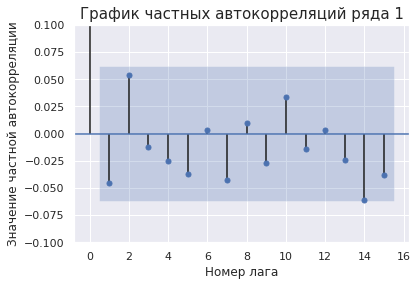

In [ ]:
plot_pacf(diff_1, lags=15)
plt.ylim(-0.1, 0.1)
plt.title('График частных автокорреляций ряда 1', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

p = 14

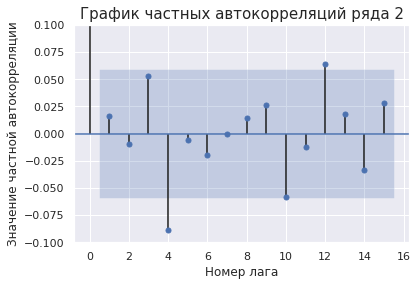

In [ ]:
plot_pacf(diff_2, lags=15)
plt.ylim(-0.1, 0.1)
plt.title('График частных автокорреляций ряда 2', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

p = 12

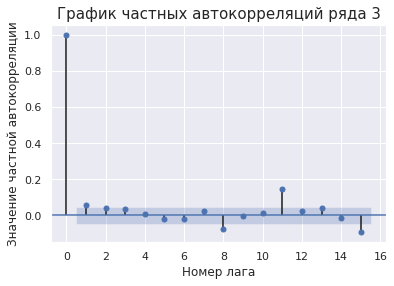

In [ ]:
plot_pacf(diff_3, lags=15)
plt.title('График частных автокорреляций ряда 3', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

p = 15

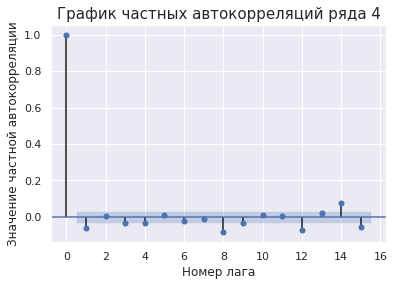

In [ ]:
plot_pacf(diff_4, lags=15)
plt.title('График частных автокорреляций ряда 4', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

p = 15

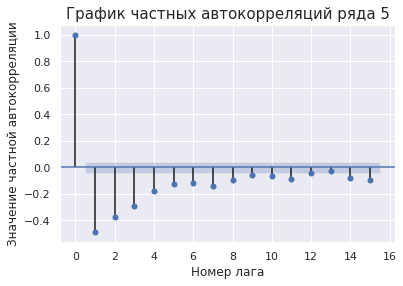

In [ ]:
plot_pacf(diff_5, lags=15)
plt.title('График частных автокорреляций ряда 5', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

p = 15

In [ ]:
p_nst = [14, 12, 15, 15, 15]
nst_series = [series_1, series_2, series_3, series_4, series_5]
results_nst = [[] for i in range(9)]
ranks_nst = [[] for i in range(5)]
xes = np.array(['Holdout', 'Rep-Holdout', 'Preq-Bls', 'Preq-Sld-Bls', 'Preq-Bls-Gap',
       'CV-Bl', 'CV-hvBl', 'Preq-Grow', 'Preq-Slide'])
st_d_nst = []
av_rank_nst = []

for i in range(len(nst_series)):
    cur_res = []
    cur_el = CVMethods(nst_series[i], 0.7, 10, (0.05 * len(nst_series[i])), p_nst[i], 10)
    lm_cur = cur_el.get_Lm()
    all_metr_nst = cur_el.get_all_metrics()
    cur_res = [np.abs(metric - lm_cur) for metric in all_metr_nst]

    sort_ind = np.argsort(cur_res)
    st_d_nst.append(sort_ind + 1)
    ranks_nst[i] = xes[sort_ind]

av_rank_nst = np.mean(st_d_nst, axis=0)
st_d_nst = np.std(st_d_nst, axis=0)

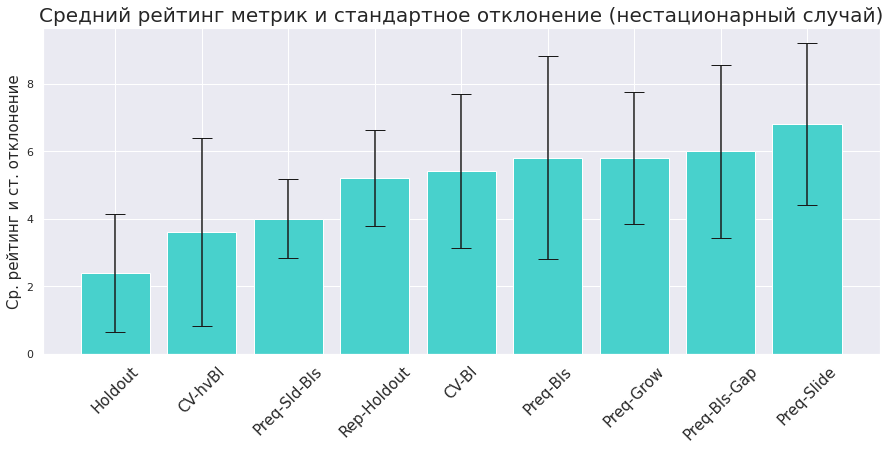

In [ ]:
plt.figure(figsize=(15, 6))
plt.grid()      

sort_ind_nst = np.argsort(av_rank_nst)
results_nst = np.sort(av_rank_nst)
xes_nst = xes[sort_ind_nst]

plt.xticks(range(len(xes_nst)), xes_nst, rotation=45, size=15)
plt.bar(xes_nst, results_nst, 0.8, yerr=st_d_nst, color='mediumturquoise', capsize=10)

plt.ylabel('Ср. рейтинг и ст. отклонение', size=15)
plt.title('Средний рейтинг метрик и стандартное отклонение (нестационарный случай)', size=20)
plt.grid()
plt.show()

In [ ]:
p_st = [14, 12, 15, 15, 15]
st_series = [diff_1, diff_2, diff_3, diff_4, diff_5]
results_st = [[] for i in range(9)]
ranks_st = [[] for i in range(5)]
st_d_st = []
av_rank_st = []

for i in range(len(st_series)):
    cur_res = []
    cur_el = CVMethods(st_series[i], 0.7, 10, (0.05 * len(st_series[i])), p_st[i], 10)
    lm_cur = cur_el.get_Lm()
    all_metr_st = cur_el.get_all_metrics()
    cur_res = [np.abs(metric - lm_cur) for metric in all_metr_st]

    sort_ind = np.argsort(cur_res)
    st_d_st.append(sort_ind + 1)
    ranks_st[i] = xes[sort_ind]

av_rank_st = np.mean(st_d_st, axis=0)
st_d_st = np.std(st_d_st, axis=0)

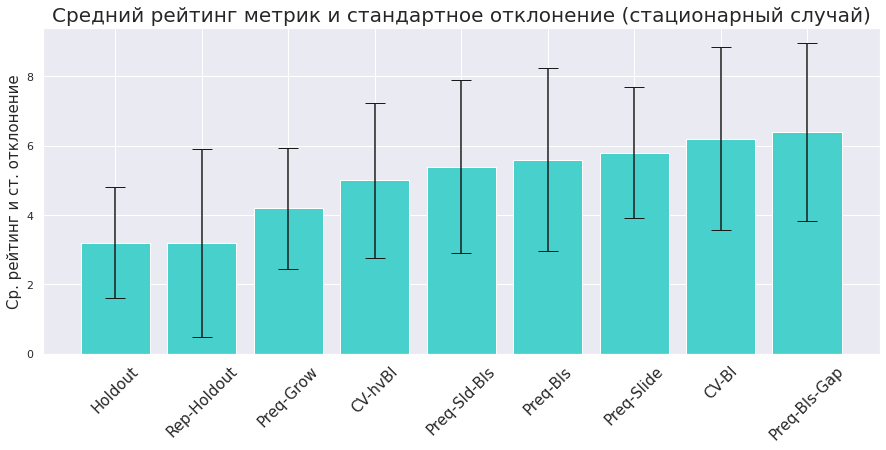

In [ ]:
plt.figure(figsize=(15, 6))
plt.grid()      

sort_ind_st = np.argsort(av_rank_st)
results_st = np.sort(av_rank_st)
xes_st = xes[sort_ind_st]

plt.xticks(range(len(xes_st)), xes_st, rotation=45, size=15)
plt.bar(xes_st, results_st, 0.8, yerr=st_d_st, color='mediumturquoise', capsize=10)

plt.ylabel('Ср. рейтинг и ст. отклонение', size=15)
plt.title('Средний рейтинг метрик и стандартное отклонение (стационарный случай)', size=20)
plt.grid()
plt.show()

#Вывод:

На самом деле не очень ясно, какой именно вывод от нас тут хотят, потому что очевидно, что наши методы и метод их применения ооооочень сильно отличаются от того, что представлено в статье. Могу даже перечислить некоторые существенные отличия:
1. Выборки рядов у нас значительно меньше, чем у создателей статьи
2. Отличается метрика, с помощью которой мы оцениваем качество (в статье RMSE, у нас MAPE)
3. Порядок авторегрессии мы берем просто равным последнему значимому лагу частичной автокорелляции, что не очень корректно, вообще говоря.  В статье же подбирается оптимальное p (насколько я поняла)
4. В методе, где нужно выкидывать часть значений ряда (preq_expanding_with_gap у нас и Preq-Bls-Gap в статье) мы выкидываем 5% исходного ряда (так было оговорено в общей беседе), а в статье же выкидывают p значений (ну на самом деле не думаю, что это прям существенно повлияет на резы)
и т.д.

Кажется, что каждый из этих факторов по отдельности не должен очень сильно влиять на результат, но так как у нас их довольно много, то получится то, что получится...

Понятно, что результаты у нас будут немного (или много) отличаться от тех, что получились в статье. Но можно в целом прокомментировать то, что вышло у нас и немного (совсем немного, насколько это можно) посравнивать со статьей. 

Для начала отвечу на вопросы из условия:
> Совпали ли результаты с выводами статьи, которые мы обсуждали? 

Нет. Выше написано почему. 

> Наблюдается ли разница между стационарными и нестационарными рядами?

Да, наблюдается. Какая именно - опишу дальше.

На самом деле ясно, что рейтинг методов кросс-валидации содержит в себе некоторую часть рандома (как минимум в методах Holdout и Rep-Holdout случайность имеется), так что от запуска к запуску рейтинг немного отличался (рисовать кучу графиков я уже не стала, чтобы не загромождать ноутбук. Но методы Holdout и Rep-Holdout всегда были в первой четверке, как для стационарных рядов, так и для нестационарных. 

Далее вставлю сюда скрины графиков из статьи, чтобы было удобнее сравнивать. Нас интересуют 16 и 17 графики. 
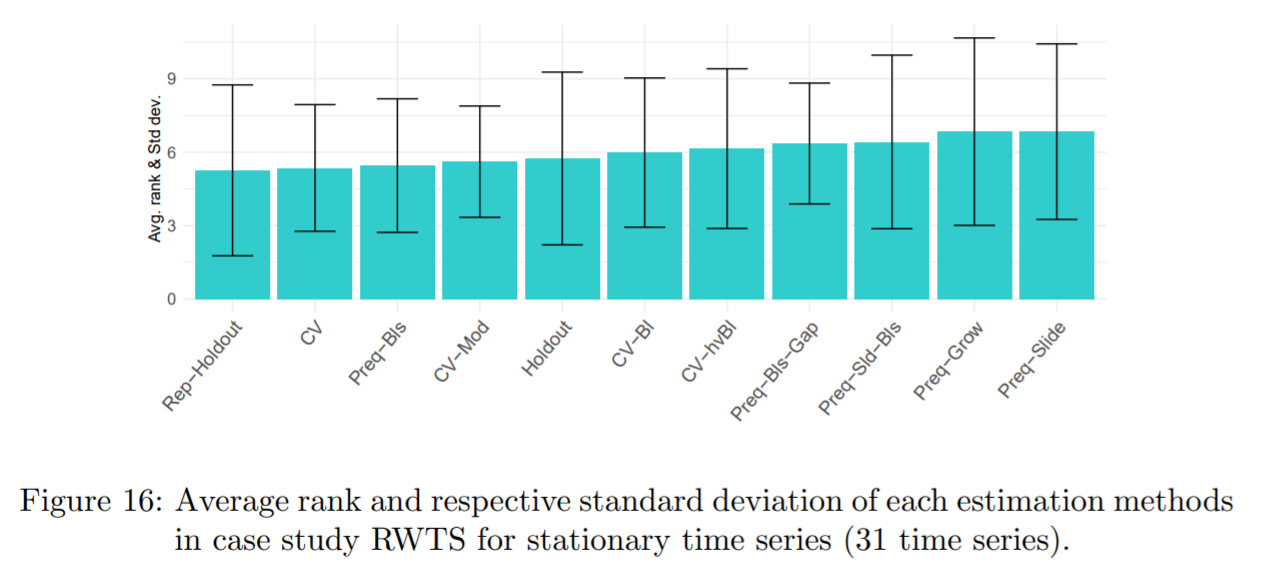

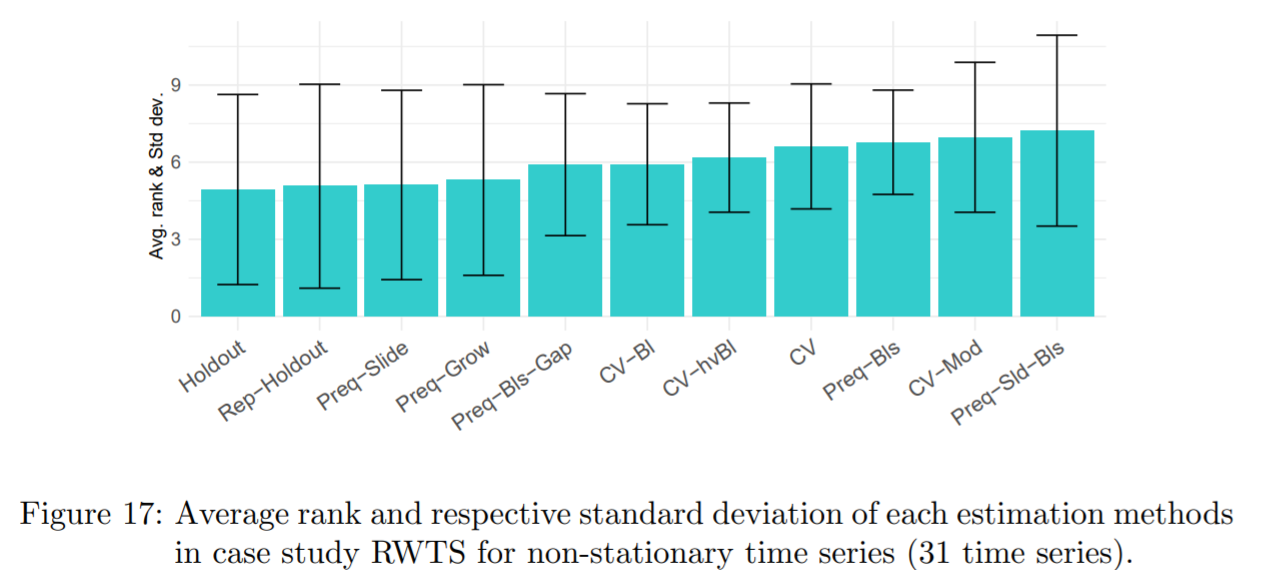

Соответственно график 16 будем сравнивать с нашим вторым (стационарный случай), а график 17 с нашим первым (нестационарный случай). У создателей статьи вышло так, что лучше всего на нестационарных рядах работает Holdout, что совпало с тем, что получилось у меня. Хотя конечно Holdout показывал разные результаты в зависимости от запуска, но всегда был одним из лучших. Также Holdout и RepHoldout у меня вышли лучшими и для стационарных рядов (вообще, какие замечательные методы то... шлю воздушный поцелуй). У создателей статье же лучшим вышел RepHoldout, но можно заметить, что особо большой разницы между первыми 5-ю методами в рейтинге нет. То есть они примерно одинаково хорошо/плохо работают. В нашем же случае вышло так, что Holdout и RepHoldout все-таки с чуть большим отрывом лучше остальных. 
Что явялется общим и для моих результатов и для результатов авторов статье - так это большой разброс. Нет такого, что какой-то метод работает лучше всех на всех рядах, а какой-то хуже всех. Это связано с тем, что все ряды имеют разную структуру и в зависимости от нее на одном ряде один метод работет лучше, а на другом - другой. Это понятно, ведь методы кросс-валидации довольно разные по своей сути. В целом они рассматривают разные части ряда (их комбинации) в качестве тестовых и обучающих данных, так некоторые ещеи выкидывают какую-то часть данных. И понятно что для какого-то специфичного ряда такой метод чисто теоретически мог бы выкинуть часть данных, которые очень важны для прогноза. И так далее. О том, почему методы работают по-разному на разных рядах можно говорить очень много + на семинаре мы об этом говорили. Как можно заметить (надеюсь, мой глазомер меня не подвел) самый большой разброс наблюдается у метода Rep-Holdout, что объяснимо. Ведь в данном случае помимо того, что у нас рыды разные имеет свой вес еще и то, что данный метод содержит в себе довольно много рандома. Он которого, конечно, тое зависит качество прогноза, так как зависит разбиение ряда).

Если говорить уже конкретно о моих результатах для стационарных и нестационарных рядов, то можно заметить, что рейтинг методов, конечно, отличается. Это опять таки из-за того, что ряды имеют разную струтуру. Но например метод Preq-Bls-Gap оказался самым зудшим или почти самым худшим для обеих случаев. Вообще результаты вышли не то, чтобы очень хорошо интепретируемые логически. Наверное, потому что я взяла какие-то совсем рандомные склеенные из непойми чего ряды, ну и плюс все факторы, о которых писала выше.

Но в общем вышло то, что вышло))) Теперь я знаю на 7 методов кросс-валидации больше, чем до этого))))))))

##Мем дня:

<img src="https://sun9-71.userapi.com/impf/DDWipchWytV3m4S5c3z3KPpKt5K7mut7-82WFQ/GkhA5cWDAUQ.jpg?size=951x1080&quality=96&proxy=1&sign=007364c797da42f0d1abccb20326c22d&type=album">